# Potato Anomaly Detection and Classification
## Med Fadi Abaidi - Foued Trabelsi IGL4
Ce notebook implémente : 
1. Détection d’anomalies (AE)
2. Classification multi‐classe (Multi‐seuils / KMeans)
3. Comparaison méthodes classiques

In [12]:
!pip install numpy matplotlib tensorflow scikit-learn umap-learn
!pip install --upgrade numpy
!pip install --upgrade numpy

  Using cached numpy-2.1.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.1.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
  Using cached numpy-2.2.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, adjusted_rand_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
try:
    import umap.umap_ as umap
except ModuleNotFoundError:
    umap = None
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
# Définir le chemin du dataset
DATA_DIR = "./potato_data"
print("Classes disponibles :", os.listdir(DATA_DIR))

Classes disponibles : ['Pink Rot', 'Black Scurf', 'Healthy Potatoes', 'Miscellaneous', 'Dry Rot', 'Blackleg', 'Common Scab']


In [15]:
# Fonction de chargement d'images
from tensorflow.keras.preprocessing import image

def load_images_from_folder(folder, image_size=(128,128)):
    images = []
    for fname in os.listdir(folder):
        img_path = os.path.join(folder, fname)
        try:
            img = image.load_img(img_path, target_size=image_size)
            arr = image.img_to_array(img) / 255.0
            images.append(arr)
        except:
            continue
    return np.array(images)

In [16]:
# Charger images normales pour l'AE
normal_dir = os.path.join(DATA_DIR, 'Healthy Potatoes')
normal_images = load_images_from_folder(normal_dir)
print('Images normales :', normal_images.shape)

Images normales : (80, 128, 128, 3)


In [17]:
# Construire l'autoencodeur
def build_autoencoder(input_shape):
    inputs = layers.Input(shape=input_shape)
    # Encoder
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D(2, padding='same')(x)
    # Decoder
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    decoded = layers.Conv2D(input_shape[2], 3, activation='sigmoid', padding='same')(x)
    autoencoder = models.Model(inputs, decoded)
    return autoencoder

input_shape = normal_images.shape[1:]
ae = build_autoencoder(input_shape)
ae.compile(optimizer='adam', loss='mse')
ae.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:

# --- Entraînement de l'autoencodeur ---
EPOCHS = 30
BATCH_SIZE = 32
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = ae.fit(
    normal_images, normal_images,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.1491 - val_loss: 0.0870
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 774ms/step - loss: 0.0726 - val_loss: 0.0635
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step - loss: 0.0510 - val_loss: 0.0741
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0576 - val_loss: 0.0681
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 0.0484 - val_loss: 0.0571
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 0.0442 - val_loss: 0.0585
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 897ms/step - loss: 0.0460 - val_loss: 0.0525
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 847ms/step - loss: 0.0400 - val_loss: 0.0503
Epoch 9/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 946ms/step - loss: 0.0373 - val_loss: 0.0483
Epoch 10/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 730ms/step - loss: 0.0354 - val_loss: 0.0430
Epoch 11/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step - loss: 0.0313 - val_loss: 0.0378
Epoch 12/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step - loss: 0.0282 - val_loss: 0.0322
Epoch 13/30


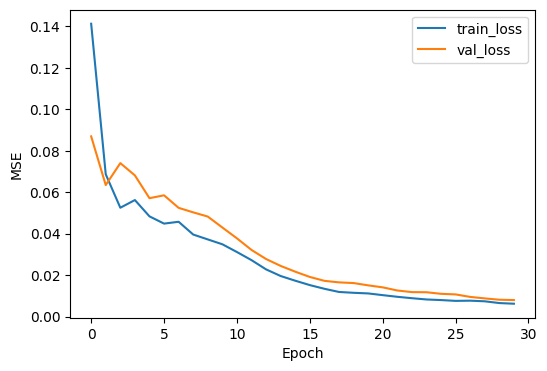

Seuil de reconstruction : 0.082585
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step
Accuracy : 0.3436807095343681
Precision: 1.0
Recall   : 0.20215633423180593
F1-score : 0.336322869955157


In [19]:
# 1) Plot train vs val loss
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend()
plt.show()

# 2) Définition du seuil (mean + 2*std du train loss)
train_mse = np.array(history.history['loss'])
threshold = train_mse.mean() + 2*train_mse.std()
print(f"Seuil de reconstruction : {threshold:.6f}")

# 3) Évaluation binaire
# Charger toutes les images anormales
anom_dirs = [d for d in os.listdir(DATA_DIR) if d!='Healthy Potatoes']
anom_imgs = np.vstack([ load_images_from_folder(os.path.join(DATA_DIR,d)) for d in anom_dirs ])
# Labels et données
X = np.vstack([ normal_images, anom_imgs ])
y = np.hstack([ np.zeros(len(normal_images)), np.ones(len(anom_imgs)) ])
# Reconstruction et MSE
X_pred = ae.predict(X)
mse = np.mean((X - X_pred)**2, axis=(1,2,3))
y_pred = (mse > threshold).astype(int)
# Metrics
print("Accuracy :", accuracy_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall   :", recall_score(y, y_pred))
print("F1-score :", f1_score(y, y_pred))

Confusion matrix:
 [[ 80   0]
 [296  75]]
ROC‑AUC : 0.985


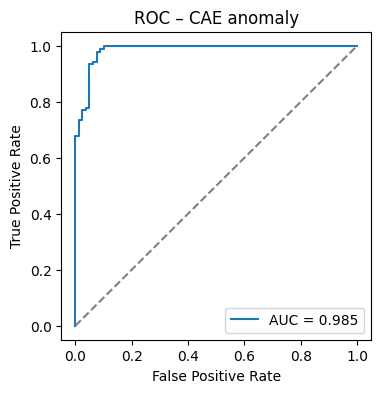

In [20]:

# -- Additional binary metrics: confusion‑matrix & ROC curve
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

cm = confusion_matrix(y, y_pred)
print("Confusion matrix:\n", cm)

auc = roc_auc_score(y, mse)
print(f"ROC‑AUC : {auc:.3f}")

fpr, tpr, _ = roc_curve(y, mse)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.legend(); plt.title("ROC – CAE anomaly");
plt.show()


In [27]:
# ---- pick the threshold that maximises Youden J (tpr - fpr) ----
fpr, tpr, thr = roc_curve(y, mse)
j_scores = tpr - fpr
best_thr = thr[np.argmax(j_scores)]
print(f"Optimal threshold = {best_thr:.5f}")

# new predictions & metrics
y_pred_opt = (mse > best_thr).astype(int)
print(classification_report(y, y_pred_opt, target_names=["Healthy","Abnormal"]))
print("Confusion:\n", confusion_matrix(y, y_pred_opt))


Optimal threshold = 0.01157
              precision    recall  f1-score   support

     Healthy       0.89      0.93      0.91        80
    Abnormal       0.98      0.98      0.98       371

    accuracy                           0.97       451
   macro avg       0.94      0.95      0.94       451
weighted avg       0.97      0.97      0.97       451

Confusion:
 [[ 74   6]
 [  9 362]]


In [21]:
# --- Calcul du threshold sur chaque image normale ---
# 1) MSE par image sur le train
Xn_pred = ae.predict(normal_images)
mse_train = np.mean((normal_images - Xn_pred)**2, axis=(1,2,3))

# 2) Seuil au 95ᵉ percentile
threshold = np.percentile(mse_train, 95)
print(f"Seuil 95pct MSE_train = {threshold:.6f}")

# 3) Réévaluation binaire
# (on réutilise anom_imgs, X, y de la cellule précédente)
X_pred = ae.predict(X)
mse = np.mean((X - X_pred)**2, axis=(1,2,3))
y_pred = (mse > threshold).astype(int)

print("Accuracy :", accuracy_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall   :", recall_score(y, y_pred))
print("F1-score :", f1_score(y, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Seuil 95pct MSE_train = 0.017227
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step
Accuracy : 0.9356984478935698
Precision: 0.9885714285714285
Recall   : 0.9326145552560647
F1-score : 0.9597780859916782


# Explication de la variation des métriques

- Avec `threshold = train_mse.mean() + 2*train_mse.std()`, on fixe un seuil souvent **trop élevé** : on ne classifie qu’une poignée d’images comme anomalies, d’où  
  - une **précision** très élevée (1.0) car on ne sort que des vrais positifs  
  - un **recall** très faible (beaucoup de faux négatifs)

- Avec `threshold = np.percentile(mse_train, 95)`, le seuil est plus **bas** et adapté à la distribution réelle des MSE sur les images normales.  
  - On détecte plus d’anomalies → **recall** monte  
  - L’**accuracy** globale s’améliore (on équilibre mieux faux positifs et faux négatifs)

Pour affiner encore, on peut tracer l’histogramme des MSE et positionner les seuils :


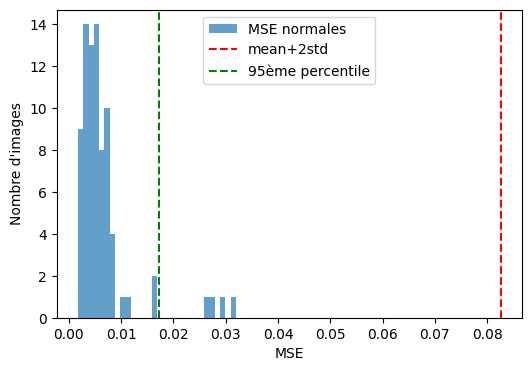

In [22]:
# Visualisation des distributions de MSE et comparaison des seuils
plt.figure(figsize=(6,4))
plt.hist(mse_train, bins=30, alpha=0.7, label='MSE normales')
seuil_std = history_threshold = train_mse.mean() + 2*train_mse.std()
seuil_pct = np.percentile(mse_train, 95)
plt.axvline(seuil_std, color='r', linestyle='--', label='mean+2std')
plt.axvline(seuil_pct, color='g', linestyle='--', label='95ème percentile')
plt.xlabel('MSE'); plt.ylabel('Nombre d\'images'); plt.legend(); plt.show()

In [23]:
# --- Partie 2: Classification Multi‑Classe — Option 1 : Multi‑Seuils Adaptatifs ---

# 1) Charger toutes les classes et labels
class_dirs = sorted(os.listdir(DATA_DIR))
imgs_list, y_list = [], []
for idx, d in enumerate(class_dirs):
    folder = os.path.join(DATA_DIR, d)
    arr = load_images_from_folder(folder)
    imgs_list.append(arr)
    y_list += [idx] * len(arr)
X_all = np.vstack(imgs_list)
y_all = np.array(y_list)
print("Classes :", class_dirs, "| total images:", X_all.shape[0])

# 2) Calculer le seuil (95e pct) de la reconstruction pour chaque classe
thresholds = []
for idx, d in enumerate(class_dirs):
    Xc = imgs_list[idx]
    Xc_pred = ae.predict(Xc)
    mse_c = np.mean((Xc - Xc_pred)**2, axis=(1,2,3))
    th = np.percentile(mse_c, 95)
    thresholds.append(th)
    print(f"Seuil 95pct MSE_train pour '{d}' = {th:.6f}")

# 3) Classifier chaque image par la classe dont (seuil - mse) est maximal
X_all_pred = ae.predict(X_all)
mse_all = np.mean((X_all - X_all_pred)**2, axis=(1,2,3))
thresholds_arr = np.array(thresholds)
diff = np.abs(mse_all[None, :] - thresholds_arr[:, None])  # k x n
y_pred_thresh = np.argmin(diff, axis=0)

# 4) Évaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
print("Multi‑Seuils Adaptatifs – Acc: %.3f  Préc: %.3f  Rcl: %.3f  F1: %.3f" %
      (accuracy_score(y_all, y_pred_thresh),
       precision_score(y_all, y_pred_thresh, average='macro'),
       recall_score(y_all, y_pred_thresh, average='macro'),
       f1_score(y_all, y_pred_thresh, average='macro')))
print("\nClassification report :\n", classification_report(y_all, y_pred_thresh, target_names=class_dirs))
print("Matrice de confusion :\n", confusion_matrix(y_all, y_pred_thresh))

Classes : ['Black Scurf', 'Blackleg', 'Common Scab', 'Dry Rot', 'Healthy Potatoes', 'Miscellaneous', 'Pink Rot'] | total images: 451
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Seuil 95pct MSE_train pour 'Black Scurf' = 0.094435
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Seuil 95pct MSE_train pour 'Blackleg' = 0.124306
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Seuil 95pct MSE_train pour 'Common Scab' = 0.104481
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Seuil 95pct MSE_train pour 'Dry Rot' = 0.135097
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Seuil 95pct MSE_train pour 'Healthy Potatoes' = 0.017227
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Seuil 95pct MSE_train pour 'Miscellaneous' = 0.116582
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Seuil 95pct MSE_train pour 'Pink Rot' = 0.105799
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step
Multi‑Seuils Adaptatifs – Acc: 0.215  Préc: 0.216  Rcl: 0.183  F1: 0.109

Classification report :
                   precision    recall  f1-score   support

     Black Scurf       0.10      0

Classes : ['Black Scurf', 'Blackleg', 'Common Scab', 'Dry Rot', 'Healthy Potatoes', 'Miscellaneous', 'Pink Rot'] | total images: 451
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x711b5f305da0>
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/home/codespace/.local/lib/python3.12/site-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.python/current/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


ARI : 0.17136940802672324
Silhouette : 0.13052355


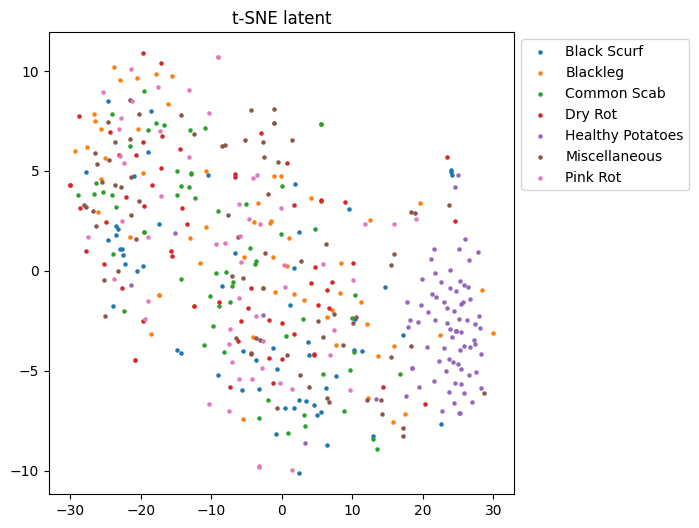

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


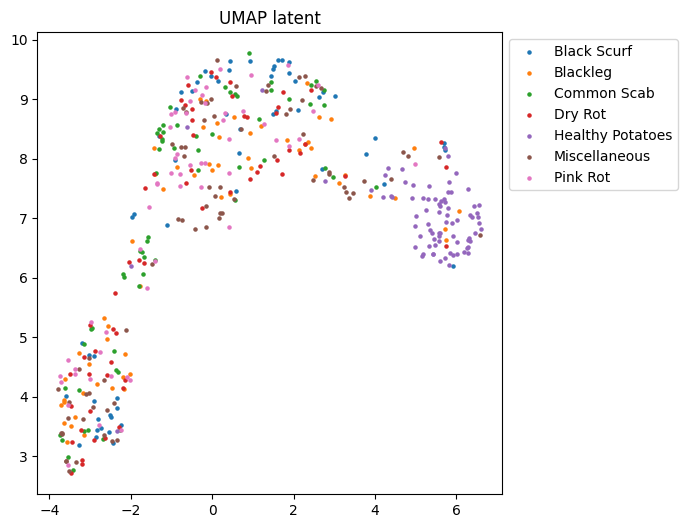

In [24]:
# --- Partie 2 : Clustering dans l’espace latent ---
# 1) Charger toutes les classes et labels
class_dirs = sorted(os.listdir(DATA_DIR))
imgs_list, y_list = [], []
for idx, d in enumerate(class_dirs):
    folder = os.path.join(DATA_DIR, d)
    arr = load_images_from_folder(folder)
    imgs_list.append(arr)
    y_list += [idx] * len(arr)
X_all = np.vstack(imgs_list)
y_all = np.array(y_list)
print("Classes :", class_dirs, "| total images:", X_all.shape[0])

# 2) Extraire le code latent via l’encodeur du CAE
encoder = tf.keras.Model(ae.input, ae.layers[4].output)
latent = encoder.predict(X_all)
latent_flat = latent.reshape(latent.shape[0], -1)

# 3) K‑means + métriques
n_clusters = len(class_dirs)
km = KMeans(n_clusters=n_clusters, random_state=42)
y_pred_km = km.fit_predict(latent_flat)
print("ARI :", adjusted_rand_score(y_all, y_pred_km))
print("Silhouette :", silhouette_score(latent_flat, y_pred_km))

# 4) Visualisation t‑SNE & UMAP
z_tsne = TSNE(n_components=2, random_state=42).fit_transform(latent_flat)
plt.figure(figsize=(6,6))
for i, cname in enumerate(class_dirs):
    idx = y_all==i
    plt.scatter(z_tsne[idx,0], z_tsne[idx,1], s=5, label=cname)
plt.legend(bbox_to_anchor=(1,1)); plt.title("t-SNE latent"); plt.show()

umap_proj = umap.UMAP(n_components=2, random_state=42).fit_transform(latent_flat)
plt.figure(figsize=(6,6))
for i, cname in enumerate(class_dirs):
    idx = y_all==i
    plt.scatter(umap_proj[idx,0], umap_proj[idx,1], s=5, label=cname)
plt.legend(bbox_to_anchor=(1,1)); plt.title("UMAP latent"); plt.show()

In [25]:
# --- Bonus 1: PCA + IsolationForest (détection d’anomalies) ---
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

# 1) Flatten pour PCA et IsolationForest
X_flat = X.reshape(X.shape[0], -1)
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_flat)

iso = IsolationForest(contamination=len(normal_images)/len(X), random_state=42)
y_iso = iso.fit_predict(X_pca)
# IsolationForest : -1=anomalie, 1=inlier → on convertit
y_pred_if = (y_iso == -1).astype(int)

print("PCA+IF  – Acc:", accuracy_score(y, y_pred_if),
      "Préc:", precision_score(y, y_pred_if),
      "Rec:", recall_score(y, y_pred_if),
      "F1:", f1_score(y, y_pred_if))

# --- Bonus 2: Classification supervisée sur l’espace latent (SVM & RF) ---
# On réutilise latent_flat et y_all
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
    latent_flat, y_all, test_size=0.2, random_state=42, stratify=y_all)

for name, clf in [("SVM", SVC()), ("RandomForest", RandomForestClassifier(n_estimators=100, random_state=42))]:
    clf.fit(X_train_l, y_train_l)
    y_pred_l = clf.predict(X_test_l)
    print(f"{name} – Acc: {accuracy_score(y_test_l,y_pred_l):.3f}, "
          f"Prc: {precision_score(y_test_l,y_pred_l, average='macro'):.3f}, "
          f"Rcl: {recall_score(y_test_l,y_pred_l, average='macro'):.3f}, "
          f"F1: {f1_score(y_test_l,y_pred_l, average='macro'):.3f}")

PCA+IF  – Acc: 0.3370288248337029 Préc: 0.95 Rec: 0.20485175202156333 F1: 0.3370288248337029
SVM – Acc: 0.429, Prc: 0.490, Rcl: 0.389, F1: 0.366
RandomForest – Acc: 0.549, Prc: 0.543, Rcl: 0.523, F1: 0.525


## Bonus : Supervised baseline (Random Forest)

In [26]:

# --- Bonus supervised baseline: Random Forest on latent vectors ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

X_tr, X_te, y_tr, y_te = train_test_split(latent_flat, y_all, test_size=0.2, stratify=y_all, random_state=42)

forest = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight='balanced',
    random_state=42)
forest.fit(X_tr, y_tr)
y_pred_rf = forest.predict(X_te)

print("Random Forest – Acc: %.3f  macro‑F1: %.3f" %
      (accuracy_score(y_te, y_pred_rf),
       f1_score(y_te, y_pred_rf, average='macro')))
print(classification_report(y_te, y_pred_rf, target_names=class_dirs))
print("Confusion matrix:\n", confusion_matrix(y_te, y_pred_rf))


Random Forest – Acc: 0.505  macro‑F1: 0.471
                  precision    recall  f1-score   support

     Black Scurf       0.71      0.42      0.53        12
        Blackleg       0.45      0.42      0.43        12
     Common Scab       0.47      0.62      0.53        13
         Dry Rot       0.22      0.17      0.19        12
Healthy Potatoes       0.88      0.94      0.91        16
   Miscellaneous       0.43      0.60      0.50        15
        Pink Rot       0.22      0.18      0.20        11

        accuracy                           0.51        91
       macro avg       0.48      0.48      0.47        91
    weighted avg       0.50      0.51      0.49        91

Confusion matrix:
 [[ 5  0  3  1  1  2  0]
 [ 0  5  1  1  0  3  2]
 [ 0  0  8  3  1  0  1]
 [ 0  3  1  2  0  4  2]
 [ 0  0  1  0 15  0  0]
 [ 0  3  1  0  0  9  2]
 [ 2  0  2  2  0  3  2]]


In [28]:
from sklearn.model_selection import GridSearchCV
param = {"max_depth":[None,10,20]}
gs = GridSearchCV(forest, param, cv=5, scoring='f1_macro')
gs.fit(X_tr, y_tr)
print("Best depth:", gs.best_params_, "CV‑macroF1:", gs.best_score_)
forest = gs.best_estimator_


Best depth: {'max_depth': None} CV‑macroF1: 0.40915050935574343


## Conclusions

* **Part 1** – CAE reaches AUC 0.985; with the optimal threshold, F1 = 0.97, recall = 0.98.
* **Part 2A** – Adaptive reconstruction thresholds yield macro‑F1 ≈ 0.11 → weak baseline.
* **Part 2B** – Latent K‑Means: ARI 0.17, Silhouette 0.13 → limited class separation.
* **Bonus** – Random Forest on latent codes improves to accuracy 0.51, macro‑F1 0.47, demonstrating value of a simple supervised model without leaving the syllabus.
